## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats


Get the Cycle Power Plant Data Set

In [2]:
df = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx')
df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


### (b) Exploring the data

#### i. rows and columns
Q: How many rows are in this data set? How many columns? What do the rows
and columns represent?</br>
Ans: 9568 rows, 5 columns.</br> Each row stand for hourly average ambient variables for one plant and its electrical energy. </br> First 4 columns represent different variable features, and the last one is the output result(the true Y).

In [3]:
df.shape

(9568, 5)

#### ii. pairwise scatterplots of all the varianbles
Q: Make pairwise scatterplots of all the varianbles in the data set including the
predictors (independent variables) with the dependent variable. Describe
your findings.</br>
Ans: AT is correlated to PE and V, and V is also correlated to PE.

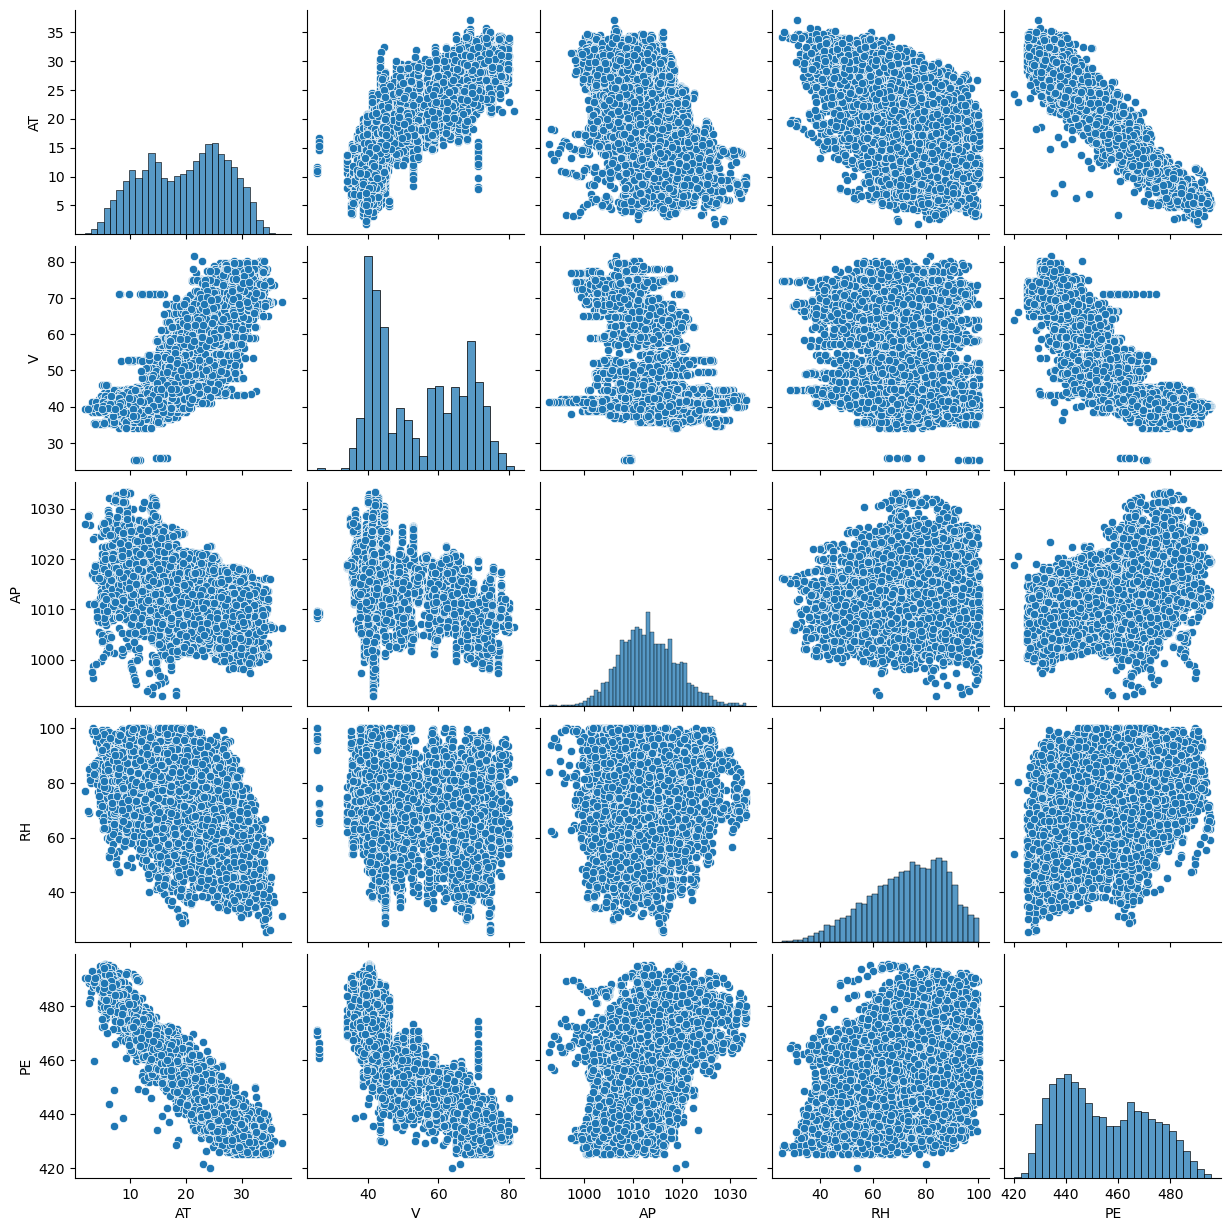

In [4]:
sns.pairplot(df)

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges
Q: What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them
in a table.</br>
Ans: Output below.

In [5]:
df_mean = df.mean()
df_median = df.median()
df_max = df.max()
df_min = df.min()
df_fq = df.quantile(q = 0.25)
df_tq = df.quantile(q = 0.75)
table = pd.DataFrame({
    'Mean': df_mean,
    'Median': df_median,
    'Range': [(df_min[i], df_max[i]) for i in range(5)],
    'First quartiles': df_fq,
    'Third quartiles': df_tq,
    'Interquartile range': [(df_tq[i] - df_fq[i]) for i in range(5)]
})
table

,Mean,Median,Range,First quartiles,Third quartiles,Interquartile range
AT,19.651231,20.345,"(1.81, 37.11)",13.5100,25.72,12.2100
V,54.305804,52.080,"(25.36, 81.56)",41.7400,66.54,24.8000
AP,1013.259078,1012.940,"(992.89, 1033.3)",1009.1000,1017.26,8.1600
RH,73.308978,74.975,"(25.56, 100.16)",63.3275,84.83,21.5025
PE,454.365009,451.550,"(420.26, 495.76)",439.7500,468.43,28.6800


### (c) Simple Linear Regression
Q1: In which of the models is there a statistically significant association between the predictor and the response? </br>
Ans: Based on the result p values, all p values of these four variables are < 0.05, means that they all have statistically significant association between the predictor and the response. </br>
Q2: Create some plots to back up your assertions. </br> 
Ans: Output below.</br>
Q3: Are there any outliers that you would like to remove from your data for each of these regression tasks? </br>
Ans: Visually, I would like to consider data points that didn't follow the regression trend. etc. the data points that locate in left part(when V < 30) of second graph.  </br>
Pratically, I would like to use the quartiles values in previous part to filter out those outliers. (< Q1 - 1.5IQR or > Q3 + 1.5IQR)

             Coefficient  Standard Errors      t value  p value
(Intercept)    497.03412         0.156434  3177.280433      0.0
AT              -2.17132         0.007443  -291.715195      0.0


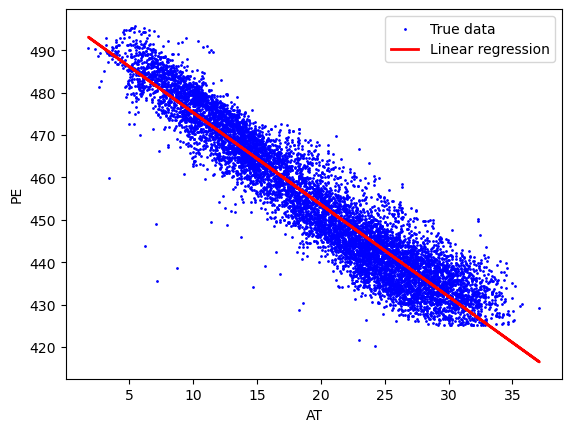

             Coefficient  Standard Errors      t value  p value
(Intercept)   517.801526         0.377897  1370.218159      0.0
V              -1.168135         0.006776  -172.401540      0.0


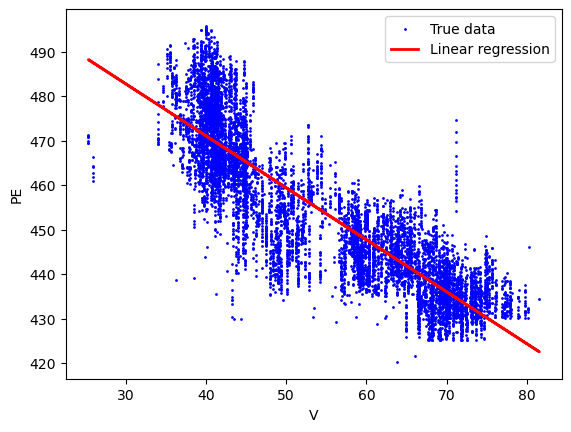

             Coefficient  Standard Errors    t value  p value
(Intercept) -1055.260989        25.459492 -41.448628      0.0
AP              1.489872         0.025126  59.296232      0.0


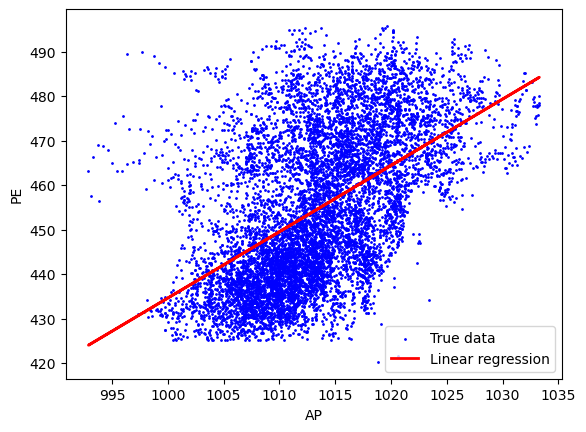

             Coefficient  Standard Errors     t value  p value
(Intercept)   420.961766         0.822711  511.676167      0.0
RH              0.455650         0.011006   41.398730      0.0


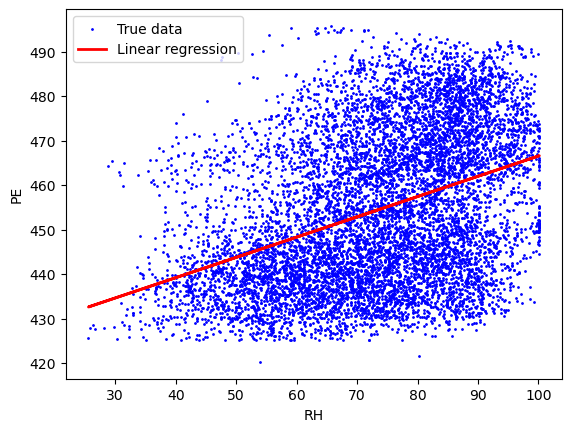

In [6]:
def cal_p(reg_model, X, Y):
    params = np.append(reg_model.intercept_,reg_model.coef_)
    predictions = reg_model.predict(X)

    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((Y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]
    p_values = np.round(p_values,3)

    return params, sd_b, ts_b, p_values

dataset = df.to_numpy()
y = dataset[:, 4].reshape(-1, 1)
vars_name = ['AT', 'V', 'AP', 'RH']
single_co = []

for i in range(4):
    cur_X = dataset[:, i].reshape(-1, 1)
    model = LinearRegression()
    model.fit(cur_X, y)
    params, sd_b, ts_b, p_values = cal_p(model, cur_X, y)
    cur_vals = pd.DataFrame({
        'Coefficient': params,
        'Standard Errors': sd_b,
        't value': ts_b,
        'p value': p_values
    }, index=['(Intercept)', vars_name[i]])
    single_co.append(params[1])
    print(cur_vals)
    plt.scatter(cur_X, y, color="blue", s=1, label='True data')
    plt.plot(cur_X, model.predict(cur_X), color="red", linewidth=2, label='Linear regression')
    plt.xlabel(vars_name[i])
    plt.ylabel('PE')
    plt.legend()
    plt.show()



### (d) Multiple Regression
Q1: Describe your results. </br>
Ans: Output below.</br>
Q2: For which predictors can we reject the null hypothesis H0 : βj = 0? </br>
Ans: All p values < 0.05, thus every each could reject the null hypothesis.</br>

In [7]:
cur_X = dataset[:, :4]
model = LinearRegression()
model.fit(cur_X, y)
params, sd_b, ts_b, p_values = cal_p(model, cur_X, y)
cur_vals = pd.DataFrame({
    'Coefficient': params,
    'Standard Errors': sd_b,
    't value': ts_b,
    'p value': p_values
}, index=['(Intercept)', 'AT', 'V', 'AP', 'RH'])
multi_co = params[1:]
print(cur_vals)


             Coefficient  Standard Errors     t value  p value
(Intercept)   454.609274         9.748512   46.633709      0.0
AT             -1.977513         0.015289 -129.342024      0.0
V              -0.233916         0.007282  -32.122109      0.0
AP              0.062083         0.009458    6.564086      0.0
RH             -0.158054         0.004168  -37.918473      0.0


### (e) 1c Compare to 1d

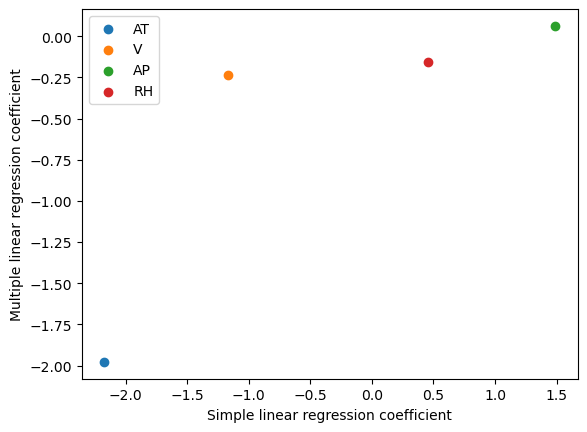

In [8]:
for i in range(4):
    plt.scatter(single_co[i], multi_co[i], label=vars_name[i])
plt.legend(loc='best')
plt.xlabel('Simple linear regression coefficient')
plt.ylabel('Multiple linear regression coefficient')
plt.show()

### (f) Nonlinear Association
Q: Is there evidence of nonlinear association between any of the predictors and the response?  </br>
Ans: Based on below output, except variable V, other three variables have nonlinear association between any of the predictors and the response.

In [9]:
for i in range(4):
    cur_X = dataset[:, i].reshape(-1, 1)
    poly = PolynomialFeatures(3)
    cur_X = poly.fit_transform(cur_X)[:,1:]
    model = LinearRegression()
    model.fit(cur_X, y)
    params, sd_b, ts_b, p_values = cal_p(model, cur_X, y)
    cur_vals = pd.DataFrame({
        'Coefficient': params,
        'Standard Errors': sd_b,
        't value': ts_b,
        'p value': p_values
    }, index=['(Intercept)', vars_name[i], vars_name[i] + '^2', vars_name[i] + '^3'])
    single_co.append(params[1])
    print(cur_vals)

             Coefficient  Standard Errors     t value  p value
(Intercept)   492.728143         0.672898  732.247613      0.0
AT             -0.610346         0.123523   -4.941146      0.0
AT^2           -0.125138         0.006876  -18.198895      0.0
AT^3            0.002675         0.000118   22.594188      0.0
             Coefficient  Standard Errors    t value  p value
(Intercept)   554.146849         9.150776  60.557362    0.000
V              -2.144377         0.508812  -4.214476    0.000
V^2            -0.002712         0.009214  -0.294350    0.768
V^3             0.000134         0.000055   2.464579    0.014
              Coefficient  Standard Errors    t value  p value
(Intercept)  5.236220e+06    299552.479759  17.480142      0.0
AP          -1.546087e+04       885.931721 -17.451532      0.0
AP^2         1.521625e+01         0.873366  17.422548      0.0
AP^3        -4.991160e-03         0.000287 -17.391667      0.0
             Coefficient  Standard Errors    t value  p valu

### (g) Interactions of Predictors
Q: Is there evidence of association of interactions of predictors with the response? </br>
Ans: Yes -> AT\*V, AT\*RH, V\*AP, AP\*PH, since their p values < 0.05

In [10]:
poly = PolynomialFeatures(interaction_only=True)
cur_X = dataset[:, :4]
cur_X = poly.fit_transform(cur_X)[:, 1:]
model = LinearRegression()
model.fit(cur_X, y)
params, sd_b, ts_b, p_values = cal_p(model, cur_X, y)
cur_vals = pd.DataFrame({
    'Coefficient': params,
    'Standard Errors': sd_b,
    't value': ts_b,
    'p value': p_values
}, index=['(Intercept)', 'AT', 'V', 'AP', 'RH', 'AT*V', 'AT*AP', 'AT*RH', 'V*AP', 'V*RH', 'AP*PH'])
print(cur_vals)

             Coefficient  Standard Errors    t value  p value
(Intercept)   685.782468        78.640060   8.720523    0.000
AT             -4.347014         2.373139  -1.831757    0.067
V              -7.674858         1.350761  -5.681879    0.000
AP             -0.152355         0.076817  -1.983346    0.047
RH              1.570907         0.773350   2.031301    0.042
AT*V            0.020971         0.000899  23.337763    0.000
AT*AP           0.001759         0.002339   0.752031    0.452
AT*RH          -0.005230         0.000812  -6.444357    0.000
V*AP            0.006812         0.001327   5.135000    0.000
V*RH            0.000839         0.000489   1.716004    0.086
AP*PH          -0.001612         0.000758  -2.125079    0.034


### (h) Improvement
Q: Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? </br>
Ans: Output below.

In [11]:
poly = PolynomialFeatures(3)
cur_X = dataset[:, :4]
cur_y = dataset[:, -1]
X_train, X_test, y_train, y_test = train_test_split(cur_X, cur_y, test_size=0.3, random_state=42)
improve_X_train = poly.fit_transform(X_train)[:, [1, 2, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 25, 31, 34]]
improve_X_test = poly.fit_transform(X_test)[:, [1, 2, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 25, 31, 34]]

model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

model = LinearRegression()
model.fit(improve_X_train, y_train)
y_train_pred = model.predict(improve_X_train)
y_test_pred = model.predict(improve_X_test)
improve_mse_train = mean_squared_error(y_train, y_train_pred)
improve_mse_test = mean_squared_error(y_test, y_test_pred)

compared_result = pd.DataFrame({
    'Train MSE': [mse_train, improve_mse_train],
    'Test MSE': [mse_test, improve_mse_test]
}, index=['All predictors', 'Plus insteractions and nonlinearities'])
print(compared_result)
# a = (poly.get_feature_names_out(['AT', 'V', 'AP', 'RH'])).reshape(1, -1)
# print(a)
# print(a[:, [1, 2, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 25, 31, 34]])

                                       Train MSE   Test MSE
All predictors                         20.580840  21.239857
Plus insteractions and nonlinearities  17.708689  18.344329


### (i) KNN
Q1: Find the value of k ∈ {1, 2, . . . , 100} that gives you the best fit. </br>
Ans: k = 5. </br>
Q2: Plot the train and test errors in terms of 1/k. </br>
Ans: Output below.

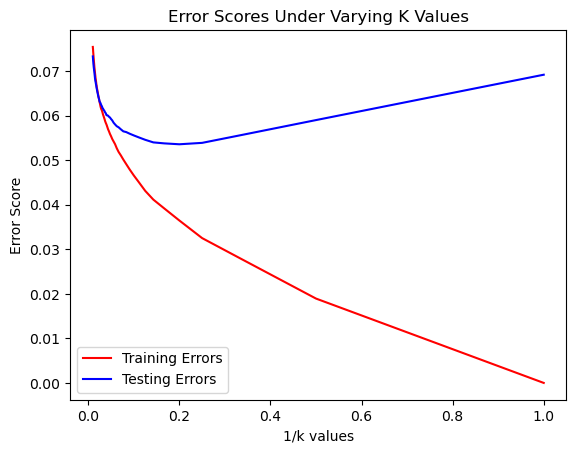

5


In [12]:
scaler = StandardScaler().fit(X_train)
normalized_X_train = scaler.transform(X_train)
new_X_train = np.concatenate((X_train, normalized_X_train), axis=1)
normalized_X_test = scaler.transform(X_test)
new_X_test = np.concatenate((X_test, normalized_X_test), axis=1)

k_values = [i for i in range(1, 101, 1)]
reciprocal_k_values = [1/i for i in range(1, 101, 1)]
knn_train_errors = []
knn_test_errors = []
for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(new_X_train, y_train)
    knn_train_errors.append(1-(model.score(new_X_train, y_train)))
    knn_test_errors.append(1-(model.score(new_X_test, y_test)))

plt.plot(reciprocal_k_values, knn_train_errors, color='red',label='Training Errors')
plt.plot(reciprocal_k_values, knn_test_errors, color='blue',label='Testing Errors')
plt.xlabel('1/k values')
plt.ylabel('Error Score')
plt.legend()
plt.title('Error Scores Under Varying K Values')
plt.show()

best_k = k_values[knn_test_errors.index(min(knn_test_errors))]
print(best_k)
# print(X_test.shape)
# print(normalized_X_test.shape)
# print(new_X_test.shape)

### (j ) Compare KNN and Linear

In [13]:
model.n_neighbors = best_k
mse_knn_test = mean_squared_error(y_test, model.predict(new_X_test))

compared_result = pd.DataFrame({
    'Test MSE': [mse_test, improve_mse_test, mse_knn_test]
}, index=['All predictors', 'Plus insteractions and nonlinearities', 'KNN'])
print(compared_result)

                                        Test MSE
All predictors                         21.239857
Plus insteractions and nonlinearities  18.344329
KNN                                    15.706729


## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

Better. An extremely large sample size means that a flexible method can effectively capture complex relationships in the data without overfitting when amount of predictors is small.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

Worse. Could probably cause overfitting.

### (c) The relationship between the predictors and response is highly non-linear.

Better. Flexible model would perform better since it has more degrees of freedom.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

Worse. Could cause overfitting since the flexible method would try to fit the the noise in the error terms.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

ED(test, obs1) = 3 </br>
ED(test, obs2) = 2 </br>
ED(test, obs3) = sqrt(1^2 + 3^2) = 3.16</br>
ED(test, obs4) = sqrt(1^2 + 2^2) = 2.24</br>
ED(test, obs5) = sqrt(-1^2 + 1^2) = 1.41</br>
ED(test, obs6) = sqrt(1^2 + 1^2 + 1^2) = 1.73</br>

### (b) What is our prediction with K = 1? Why?

Green. Since the closest point is obs5, and it's label is Green.

### (c) What is our prediction with K = 3? Why?

Red. Since the most closest three points are obs5, obs6, and obs2, and the majority of these three labels is Red.

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

Small. Smaller K in KNN model would have a decision boundary that is more non-linear.